## Group No 72

## Group Member Names:
1. SHIVAM SAHIL - 2023AA05663
2. JAHNAVI GALI - 2023AA05684
3. PRASHANT KUMAR - 2023AA05043
4. SAHIL MEHRA - 2023AA05327

In [ ]:
# Necessary Imports
import os
import random
import numpy as np
import pandas as pd
from PIL import Image

import torch
import torch.utils.data
import torchvision
import torchvision.transforms as T
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torchvision.models.detection import FasterRCNN_ResNet50_FPN_Weights
import torchvision.transforms.functional as F
from tqdm import tqdm
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from google.colab import drive
import copy

In [ ]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [ ]:
checkpoints_path = r"drive/MyDrive/temp_db/2907/checkpoints"
steps_per_checkpoint = 1200  # Save a checkpoint every 100 training steps

## Data Preprocessing

Implement necessary preprocessing steps such as normalization, resizing, and semantic segmentation to prepare data for model input - Data extraction and fusing multi-source data

In [ ]:
# Fusing Multi Source Data

class MOTDataset(torch.utils.data.Dataset):
    """
    PyTorch Dataset for a (potentially small) subset of MOT17 or similar data.
    """
    def __init__(self,
                 root_dir,
                 start_frame=1,
                 end_frame=300,
                 transforms=None,
                 min_visibility=0.3,
                 only_person=True):
        super().__init__()
        self.root_dir = root_dir
        self.img_dir = os.path.join(root_dir, "img1")
        self.ann_file = os.path.join(root_dir, "gt", "gt.txt")
        self.transforms = transforms
        self.start_frame = start_frame
        self.end_frame = end_frame
        self.min_visibility = min_visibility
        self.only_person = only_person

        # Read the annotation file
        ann_cols = ["frame","id","x","y","w","h","conf","class","visibility"]
        df = pd.read_csv(self.ann_file, header=None, names=ann_cols)

        # Keep only frames in desired range
        df = df[(df["frame"] >= self.start_frame) & (df["frame"] <= self.end_frame)]

        # Filter out low-visibility or low-confidence boxes
        df = df[df["visibility"] >= self.min_visibility]
        df = df[df["conf"] == 1]  # keep only confident = 1

        if self.only_person:
            # Typically 'class=1' in MOT indicates pedestrian
            df = df[df["class"] == 1]

        # Group by frame
        self.frames_data = df.groupby("frame")

        # Sorted list of valid frames
        self.valid_frames = sorted(self.frames_data.groups.keys())

    def __len__(self):
        return len(self.valid_frames)

    def __getitem__(self, idx):
        frame_num = self.valid_frames[idx]
        # Build image path
        img_filename = f"{frame_num:06d}.jpg"
        img_path = os.path.join(self.img_dir, img_filename)

        # Load image
        img = Image.open(img_path).convert("RGB")

        # Gather bounding boxes for this frame
        df_frame = self.frames_data.get_group(frame_num)

        boxes = []
        labels = []
        for _, row in df_frame.iterrows():
            xmin = row["x"]
            ymin = row["y"]
            xmax = xmin + row["w"]
            ymax = ymin + row["h"]
            boxes.append([xmin, ymin, xmax, ymax])
            # For MOT, label = 1 for person
            labels.append(1)

        boxes = torch.as_tensor(boxes, dtype=torch.float32)
        labels = torch.as_tensor(labels, dtype=torch.int64)

        # Additional fields
        image_id = torch.tensor([idx])
        area = (boxes[:, 3] - boxes[:, 1]) * (boxes[:, 2] - boxes[:, 0])
        iscrowd = torch.zeros((boxes.shape[0],), dtype=torch.int64)

        target = {
            "boxes": boxes,
            "labels": labels,
            "image_id": image_id,
            "area": area,
            "iscrowd": iscrowd,
            "frame_num": torch.tensor([frame_num])  # helps with tracking logic
        }

        if self.transforms:
            img, target = self.transforms(img, target)

        return img, target




### a. Extract frames from video sequences and perform normalization to standardize input data.

### b. Implement data augmentation techniques such as random cropping, flipping, and color jittering to improve model robustness.

In [ ]:
class CustomTransforms:
    def __init__(self, train=True):
        self.train = train
        self.color_jitter = T.ColorJitter(
            brightness=0.2,
            contrast=0.2,
            saturation=0.2,
            hue=0.1
        )
        self.to_tensor = T.ToTensor()

        # Normalize the data
        self.normalize = T.Normalize(
            mean=[0.485, 0.456, 0.406],
            std=[0.229, 0.224, 0.225]
        )
    # Random Cropping
    def random_crop(self, image, target, p=0.5):
      if random.random() < p:
          # Save original image and target in case we need to revert
          orig_image = image
          orig_target = copy.deepcopy(target)

          w, h = image.size
          # Use 0.4 or lesser region to crop - so that 0.6 of total image always remains intact
          new_w = random.randint(int(0.6 * w), w)
          new_h = random.randint(int(0.6 * h), h)
          left = random.randint(0, w - new_w)
          top = random.randint(0, h - new_h)
          right = left + new_w
          bottom = top + new_h

          # Crop the image
          image = image.crop((left, top, right, bottom))

          # Adjust bounding boxes
          boxes = target["boxes"]
          new_boxes = []
          new_labels = []
          for i, box in enumerate(boxes):
              x_min, y_min, x_max, y_max = box.tolist() if torch.is_tensor(box) else box
              new_xmin = max(x_min - left, 0)
              new_ymin = max(y_min - top, 0)
              new_xmax = min(x_max - left, new_w)
              new_ymax = min(y_max - top, new_h)
              if new_xmax > new_xmin and new_ymax > new_ymin:
                  new_boxes.append([new_xmin, new_ymin, new_xmax, new_ymax])
                  new_labels.append(target["labels"][i])

          # If all boxes got cropped out, skip cropping.
          if len(new_boxes) == 0:
              return orig_image, orig_target

          # Update target with new boxes and labels
          target["boxes"] = torch.tensor(new_boxes, dtype=torch.float32)
          target["labels"] = torch.tensor(new_labels, dtype=torch.int64)

      return image, target

    # Flipping
    def random_horizontal_flip(self, image, target, p=0.5):
        if random.random() < p:
            w, h = image.size
            image = F.hflip(image)
            boxes = target["boxes"]
            boxes[:, [0, 2]] = w - boxes[:, [2, 0]]
            target["boxes"] = boxes
        return image, target

    def __call__(self, image, target):
        if self.train:
          # Color Jittering
          image = self.color_jitter(image)
          # Random Cropping
          image, target = self.random_crop(image, target, p=0.5)
          # Flipping
          image, target = self.random_horizontal_flip(image, target, p=0.5)
        image = self.to_tensor(image)
        image = self.normalize(image)
        return image, target


## Model Development
### c. Design a Faster R-CNN model for object detection, fine-tuning it on the selected dataset.

We are using pretrained Faster R-CNN with ResNet-50 FPN as backbone.

We replace the final predictor with (num_classes) outputs (1 background + N classes).


In [ ]:
##############################################
# 2. MODEL DEVELOPMENT (FASTER R-CNN)
##############################################

def get_faster_rcnn_model(num_classes=2):
    model = torchvision.models.detection.fasterrcnn_resnet50_fpn(weights=FasterRCNN_ResNet50_FPN_Weights.DEFAULT)
    in_features = model.roi_heads.box_predictor.cls_score.in_features
    model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)
    return model

### d. Integrate a temporal consistency check mechanism to ensure that detected objects maintain consistent identities across frames.

We have created Minimalistic tracker using a distance-based or IoU-based approach (inspired by SORT) with 'KalmanFilter' stubs or bounding-box smoothing.

### e. Implement adaptive tracking algorithms (e.g., Kalman filter or SORT) that adjust tracking parameters based on object speed and direction.


In [ ]:
##############################################
# 3. TEMPORAL CONSISTENCY + ADAPTIVE TRACKING
##############################################

import numpy as np

class KalmanFilter:
    def __init__(self, initial_state, dt=1.0):
        self.dt = dt
        # State vector: [x, y, vx, vy]
        self.x = np.array(initial_state, dtype=float)
        self.P = np.eye(4) * 100.0  # high initial uncertainty
        self.F = np.array([[1, 0, dt, 0],
                           [0, 1, 0, dt],
                           [0, 0, 1, 0],
                           [0, 0, 0, 1]])
        # We only measure positions (x, y)
        self.H = np.array([[1, 0, 0, 0],
                           [0, 1, 0, 0]])
        self.R = np.eye(2) * 10.0  # measurement noise
        self.Q = np.eye(4)         # process noise

    def predict(self):
        self.x = self.F @ self.x
        self.P = self.F @ self.P @ self.F.T + self.Q
        return self.x

    def update(self, measurement):
        z = np.array(measurement, dtype=float)
        y = z - (self.H @ self.x)
        S = self.H @ self.P @ self.H.T + self.R
        K = self.P @ self.H.T @ np.linalg.inv(S)
        self.x = self.x + K @ y
        self.P = (np.eye(len(self.x)) - K @ self.H) @ self.P

class CombinedSORTTracker:
    def __init__(self, max_distance=50.0, iou_threshold=0.3, dt=1.0,
                 alpha=0.8, beta=0.2, cost_threshold=1.5, normalizer=100.0, max_age=5):
        """
        max_distance: maximum allowed center distance for matching
        iou_threshold: threshold for IoU matching (for reference)
        dt: time delta for the Kalman filter
        alpha: weight for the IoU component (using 1 - IoU)
        beta: weight for the normalized center distance
        cost_threshold: maximum allowed combined cost to assign a detection to a track
        normalizer: normalizing factor for the Euclidean distance
        max_age: maximum frames a track can go without assignment
        """
        self.next_id = 1
        self.tracks = {}  # track_id -> (KalmanFilter, last_frame, last_box, age)
        self.max_distance = max_distance
        self.iou_threshold = iou_threshold
        self.dt = dt
        self.alpha = alpha
        self.beta = beta
        self.cost_threshold = cost_threshold
        self.normalizer = normalizer
        self.max_age = max_age

    def _iou(self, boxA, boxB):
        xA = max(boxA[0], boxB[0])
        yA = max(boxA[1], boxB[1])
        xB = min(boxA[2], boxB[2])
        yB = min(boxA[3], boxB[3])
        interArea = max(0, xB - xA) * max(0, yB - yA)
        areaA = (boxA[2] - boxA[0]) * (boxA[3] - boxA[1])
        areaB = (boxB[2] - boxB[0]) * (boxB[3] - boxB[1])
        iou = interArea / float(areaA + areaB - interArea + 1e-6)
        return iou

    def _distance(self, box, pred_box):
        center_box = [(box[0] + box[2]) / 2, (box[1] + box[3]) / 2]
        center_pred = [(pred_box[0] + pred_box[2]) / 2, (pred_box[1] + pred_box[3]) / 2]
        return np.sqrt((center_box[0] - center_pred[0])**2 + (center_box[1] - center_pred[1])**2)

    def update(self, frame_num, detections):
        """
        detections: list of tuples (det_box, score), where det_box is [x1, y1, x2, y2]
        """
        # Step 1: Predict new state for each track and update age.
        predicted_tracks = {}
        for track_id, (kf, last_frame, last_box, age) in list(self.tracks.items()):
            pred_state = kf.predict()  # [x, y, vx, vy]
            width = last_box[2] - last_box[0]
            height = last_box[3] - last_box[1]
            pred_box = [pred_state[0] - width/2, pred_state[1] - height/2,
                        pred_state[0] + width/2, pred_state[1] + height/2]
            predicted_tracks[track_id] = (kf, pred_box)
            # Increase age if not updated in current frame.
            self.tracks[track_id] = (kf, last_frame, last_box, age + 1)

        # Step 2: Compute cost and assign detections.
        assignments = {}
        used_detections = set()
        for track_id, (kf, pred_box) in predicted_tracks.items():
            best_cost = float('inf')
            best_det_idx = None
            for i, (det_box, score) in enumerate(detections):
                if i in used_detections:
                    continue
                iou_val = self._iou(det_box, pred_box)
                dist = self._distance(det_box, pred_box)
                cost = self.alpha * (1 - iou_val) + self.beta * (dist / self.normalizer)
                # print(f"Track {track_id} - Detection {i}: IoU {iou_val:.3f}, Dist {dist:.2f}, Cost {cost:.3f}")
                if cost < best_cost:
                    best_cost = cost
                    best_det_idx = i

            if best_cost < self.cost_threshold or (best_det_idx is not None and self._iou(detections[best_det_idx][0], pred_box) > 0.2):
                assignments[track_id] = best_det_idx
                used_detections.add(best_det_idx)
                # Reset age on assignment
                kf, _, _, _ = self.tracks[track_id]
                det_box, score = detections[best_det_idx]
                self.tracks[track_id] = (kf, frame_num, det_box, 0)

        # Step 3: Update assigned tracks with measurement.
        for track_id, det_idx in assignments.items():
            det_box, score = detections[det_idx]
            measurement = [(det_box[0] + det_box[2]) / 2, (det_box[1] + det_box[3]) / 2]
            self.tracks[track_id][0].update(measurement)

        # Step 4: Create new tracks for detections that weren’t assigned.
        for i, (det_box, score) in enumerate(detections):
            if i not in used_detections:
                measurement = [(det_box[0] + det_box[2]) / 2, (det_box[1] + det_box[3]) / 2]
                kf = KalmanFilter(initial_state=[measurement[0], measurement[1], 0, 0], dt=self.dt)
                self.tracks[self.next_id] = (kf, frame_num, det_box, 0)
                self.next_id += 1

        # Step 5: Remove stale tracks.
        stale_ids = [tid for tid, (_, _, _, age) in self.tracks.items() if age > self.max_age]
        for tid in stale_ids:
            del self.tracks[tid]

        # Step 6: Build output using the current state.
        results = []
        for track_id, (kf, last_frame, last_box, age) in self.tracks.items():
            width = last_box[2] - last_box[0]
            height = last_box[3] - last_box[1]
            state = kf.x
            box = [state[0] - width/2, state[1] - height/2,
                   state[0] + width/2, state[1] + height/2]
            results.append((track_id, box))
        return results

## Evaluation Metrics
### f. Evaluate the model's performance using metrics such as mean Average Precision (mAP), tracking accuracy, and identity switch rate.

For baseline, we'll use:

    1. A simple tracker without temporal consistency
    2. Raw Faster R-CNN detections without tracking



In [ ]:
# Create a simpler tracker for comparison (just using IoU without velocity)
class SimpleIOUTracker:
    def __init__(self, iou_threshold=0.5):
        self.next_id = 1
        self.tracks = {}  # id -> bbox
        self.iou_threshold = iou_threshold

    def update(self, frame_num, detections):
        assigned = {}
        track_updates = {}
        used_detections = set()

        # Match existing tracks with new detections
        for t_id, t_box in self.tracks.items():
            best_iou = 0
            best_det_idx = None
            for i, (det_box, score) in enumerate(detections):
                if i in used_detections:
                    continue
                iou_val = iou(t_box, det_box)
                if iou_val > best_iou:
                    best_iou = iou_val
                    best_det_idx = i

            if best_iou > self.iou_threshold and best_det_idx is not None:
                det_box, _ = detections[best_det_idx]
                track_updates[t_id] = det_box
                used_detections.add(best_det_idx)

        # Any detection not assigned => new track
        for i, (det_box, score) in enumerate(detections):
            if i not in used_detections:
                track_updates[self.next_id] = det_box
                self.next_id += 1

        # Update tracks
        self.tracks = track_updates

        # Build output (id, bbox)
        results = [(t_id, t_box) for t_id, t_box in self.tracks.items()]
        return results

In [ ]:
##############################################
# 7. ADDING PERFORMANCE COMPARISON
##############################################

def compare_with_baseline(model, tracker, dataset, device, threshold=0.5):
    """
    Args:
        model: Trained Faster R-CNN model
        tracker: Our tracker implementation
        dataset: Validation dataset
        device: Device to run computations on
        threshold: Detection confidence threshold

    Returns:
        Dictionary of comparison metrics
    """
    # Initialize metrics
    metrics = {
        'our_approach': {
            'detections': 0,
            'true_positives': 0,
            'id_switches': 0
        },
        'no_tracking': {
            'detections': 0,
            'true_positives': 0,
        },
        'simple_iou_tracker': {
            'detections': 0,
            'true_positives': 0,
            'id_switches': 0
        }
    }

    # Create a simple IoU tracker
    simple_tracker = SimpleIOUTracker()

    # Track identity switches for both trackers
    last_matched_ids = {'our_approach': {}, 'simple_iou_tracker': {}}

    # Process each frame
    for idx in tqdm(range(len(dataset)), desc="Comparing with baseline"):
        img, target = dataset[idx]
        frame_num = target["frame_num"].item()
        gt_boxes = target["boxes"].numpy()

        model.eval()
        with torch.no_grad():
            # Detect objects in the frame
            detection = model([img.to(device)])[0]

        # Process raw detections
        pred_boxes = detection["boxes"].cpu().numpy()
        scores = detection["scores"].cpu().numpy()

        # Filter by threshold
        high_conf_indices = np.where(scores > threshold)[0]
        pred_boxes = pred_boxes[high_conf_indices]
        scores = scores[high_conf_indices]

        # Create list of (bbox, score) for trackers
        detections = [(box, score) for box, score in zip(pred_boxes, scores)]

        # 1. Our approach: Update our tracker
        our_tracks = tracker.update(frame_num, detections)
        our_track_boxes = [box for _, box in our_tracks]
        our_track_ids = [tid for tid, _ in our_tracks]

        # 2. Simple IOU tracker: Update simple tracker
        simple_tracks = simple_tracker.update(frame_num, detections)
        simple_track_boxes = [box for _, box in simple_tracks]
        simple_track_ids = [tid for tid, _ in simple_tracks]

        # 3. No tracking: Just use raw detections
        no_track_boxes = pred_boxes

        # Count detections
        metrics['our_approach']['detections'] += len(our_track_boxes)
        metrics['simple_iou_tracker']['detections'] += len(simple_track_boxes)
        metrics['no_tracking']['detections'] += len(no_track_boxes)

        # Evaluate against ground truth
        for approach, boxes, ids in [
            ('our_approach', our_track_boxes, our_track_ids),
            ('simple_iou_tracker', simple_track_boxes, simple_track_ids)
        ]:
            # Match with ground truth
            for gt_idx, gt_box in enumerate(gt_boxes):
                best_iou = 0.5  # IoU threshold
                best_match = -1

                for j, box in enumerate(boxes):
                    iou_val = iou(gt_box, box)
                    if iou_val > best_iou:
                        best_iou = iou_val
                        best_match = j

                if best_match >= 0:
                    # We have a match (true positive)
                    metrics[approach]['true_positives'] += 1

                    # Check for ID switch
                    gt_key = tuple(gt_box.tolist())
                    if gt_key in last_matched_ids[approach]:
                        if last_matched_ids[approach][gt_key] != ids[best_match]:
                            metrics[approach]['id_switches'] += 1

                    # Update last matched ID
                    last_matched_ids[approach][gt_key] = ids[best_match]

        # For no tracking approach (just detections)
        for gt_box in gt_boxes:
            best_iou = 0.5
            for box in no_track_boxes:
                iou_val = iou(gt_box, box)
                if iou_val > best_iou:
                    best_iou = iou_val
                    metrics['no_tracking']['true_positives'] += 1
                    break

    # Calculate comparative metrics
    for approach in metrics:
        metrics[approach]['precision'] = metrics[approach]['true_positives'] / max(1, metrics[approach]['detections'])
        metrics[approach]['recall'] = metrics[approach]['true_positives'] / max(1, len(dataset) * 5)  # Assuming ~5 objects per frame

        if approach != 'no_tracking':
            metrics[approach]['id_switch_rate'] = metrics[approach]['id_switches'] / len(dataset)

    return metrics

def compute_average_precision(detections, ground_truths, iou_threshold=0.5):
    """
    Compute Average Precision for a specific class.

    Args:
        detections: List of (boxes, scores) tuples for each image
        ground_truths: List of ground truth boxes for each image
        iou_threshold: IoU threshold for considering a detection as correct

    Returns:
        Average Precision score
    """
    # Total number of ground truth boxes across all images
    total_gt = sum(len(gt) for gt in ground_truths)

    if total_gt == 0:
        return 0.0

    # Flatten all detections across images
    all_scores = []
    all_matched = []

    # Keep track of which ground truth boxes have been matched
    gt_matched = []
    for i in range(len(ground_truths)):
        gt_matched.append(np.zeros(len(ground_truths[i]), dtype=bool))

    # Process each image
    for i in range(len(detections)):
        boxes, scores = detections[i]
        gt_boxes = ground_truths[i]

        for j in range(len(boxes)):
            all_scores.append(scores[j])

            # Check if this detection matches any ground truth
            best_iou = 0
            best_gt_idx = -1

            for k in range(len(gt_boxes)):
                if gt_matched[i][k]:
                    continue  # Skip already matched ground truths

                iou_val = iou(boxes[j], gt_boxes[k])
                if iou_val > best_iou:
                    best_iou = iou_val
                    best_gt_idx = k

            # Consider match if IoU > threshold
            if best_iou >= iou_threshold and best_gt_idx >= 0:
                all_matched.append(1)
                gt_matched[i][best_gt_idx] = True
            else:
                all_matched.append(0)

    # Sort by confidence score
    indices = np.argsort(-np.array(all_scores))
    all_matched = np.array(all_matched)[indices]

    # Compute cumulative TP and FP
    tp = np.cumsum(all_matched)
    fp = np.cumsum(1 - all_matched)

    # Compute precision and recall
    precision = tp / (tp + fp + 1e-10)
    recall = tp / total_gt

    # Compute AP using 11-point interpolation
    ap = 0
    for t in np.arange(0, 1.1, 0.1):
        if np.sum(recall >= t) == 0:
            p = 0
        else:
            p = np.max(precision[recall >= t])
        ap += p / 11

    return ap

def iou(boxA, boxB):
    """
    Compute IoU between two boxes [x1, y1, x2, y2].
    """
    xA = max(boxA[0], boxB[0])
    yA = max(boxA[1], boxB[1])
    xB = min(boxA[2], boxB[2])
    yB = min(boxA[3], boxB[3])

    # Compute area of intersection
    interArea = max(0, xB - xA) * max(0, yB - yA)

    # Compute area of both boxes
    boxAArea = (boxA[2] - boxA[0]) * (boxA[3] - boxA[1])
    boxBArea = (boxB[2] - boxB[0]) * (boxB[3] - boxB[1])

    # Compute IoU
    iou = interArea / float(boxAArea + boxBArea - interArea + 1e-10)
    return iou


def compute_tracking_accuracy_and_id_switches(tracker_results, ground_truth):
    """
    Compute tracking accuracy and identity switch rate.

    Args:
        tracker_results: Dictionary mapping frame_num to list of (track_id, bbox)
        ground_truth: Dictionary mapping frame_num to list of gt_boxes

    Returns:
        tracking_accuracy: Overall tracking accuracy (MOTA-inspired metric)
        identity_switch_rate: Rate of ID switches per frame
    """
    # Initialize counters
    total_gt = 0
    total_matches = 0
    total_misses = 0
    total_false_positives = 0
    total_id_switches = 0

    # Dictionary to keep track of last matched track_id for each gt box
    last_matched_ids = {}

    # Process each frame
    common_frames = sorted(set(tracker_results.keys()) & set(ground_truth.keys()))

    for frame_num in common_frames:
        tracker_boxes = [box for _, box in tracker_results[frame_num]]
        tracker_ids = [tid for tid, _ in tracker_results[frame_num]]
        gt_boxes = ground_truth[frame_num]

        total_gt += len(gt_boxes)

        # Keep track of which ground truth and tracker boxes have been matched
        gt_matched = [False] * len(gt_boxes)
        tracker_matched = [False] * len(tracker_boxes)

        # Match ground truth with tracker boxes using IoU
        for i, gt_box in enumerate(gt_boxes):
            best_iou = 0.5  # Minimum IoU threshold
            best_match = -1

            for j, tracker_box in enumerate(tracker_boxes):
                if tracker_matched[j]:
                    continue

                iou_val = iou(gt_box, tracker_box)
                if iou_val > best_iou:
                    best_iou = iou_val
                    best_match = j

            if best_match >= 0:
                # We have a match
                gt_matched[i] = True
                tracker_matched[best_match] = True

                # Check if there's an ID switch
                gt_idx = tuple(gt_box.tolist())  # Convert to hashable tuple
                if gt_idx in last_matched_ids:
                    if last_matched_ids[gt_idx] != tracker_ids[best_match]:
                        total_id_switches += 1

                # Update last matched ID
                last_matched_ids[gt_idx] = tracker_ids[best_match]
                total_matches += 1
            else:
                total_misses += 1

        # Count false positives
        total_false_positives += sum(not x for x in tracker_matched)

    # Compute MOTA-inspired tracking accuracy
    tracking_accuracy = 1 - (total_misses + total_false_positives + total_id_switches) / max(1, total_gt)

    # Compute identity switch rate (ID switches per frame)
    identity_switch_rate = total_id_switches / len(common_frames) if common_frames else 0

    return tracking_accuracy, identity_switch_rate

@torch.no_grad()
def compute_map(model, data_loader, device, iou_threshold=0.5):
    """
    Compute mean Average Precision (mAP) at a given IoU threshold.

    Args:
        model: The detection model
        data_loader: DataLoader for the validation set
        device: Device to run computations on
        iou_threshold: IoU threshold for considering a detection as correct

    Returns:
        mAP: Mean Average Precision score
    """
    model.eval()

    # Lists to store precision and recall values for each class
    all_detections = []
    all_ground_truths = []

    # Collect all predictions and ground truths
    for images, targets in tqdm(data_loader, desc="Computing mAP"):
        images = [img.to(device) for img in images]
        # Get model predictions
        outputs = model(images)

        for i, output in enumerate(outputs):
            pred_boxes = output["boxes"].cpu().numpy()
            pred_scores = output["scores"].cpu().numpy()
            pred_labels = output["labels"].cpu().numpy()

            gt_boxes = targets[i]["boxes"].cpu().numpy()
            gt_labels = targets[i]["labels"].cpu().numpy()

            # Store predictions and ground truths for this image
            all_detections.append((pred_boxes, pred_scores, pred_labels))
            all_ground_truths.append((gt_boxes, gt_labels))

    # Compute AP for each class (in this case, just "person" class=1)
    class_ids = [1]  # Person class
    aps = []

    for class_id in class_ids:
        # Get detections and ground truths for this class
        class_detections = []
        class_ground_truths = []

        for i in range(len(all_detections)):
            pred_boxes, pred_scores, pred_labels = all_detections[i]
            gt_boxes, gt_labels = all_ground_truths[i]

            # Filter by class
            class_pred_indices = np.where(pred_labels == class_id)[0]
            class_gt_indices = np.where(gt_labels == class_id)[0]

            class_pred_boxes = pred_boxes[class_pred_indices]
            class_pred_scores = pred_scores[class_pred_indices]
            class_gt_boxes = gt_boxes[class_gt_indices]

            # Sort predictions by confidence score (descending)
            sorted_indices = np.argsort(-class_pred_scores)
            class_pred_boxes = class_pred_boxes[sorted_indices]
            class_pred_scores = class_pred_scores[sorted_indices]

            class_detections.append((class_pred_boxes, class_pred_scores))
            class_ground_truths.append(class_gt_boxes)

        # Compute precision and recall
        ap = compute_average_precision(class_detections, class_ground_truths, iou_threshold)
        aps.append(ap)

    # Return mean AP across all classes
    return np.mean(aps)

## Evaluation

Additional code added for checkpointing iterations as the process needs lot of compute and is extremely slow in CPUs.

This piece of code regularly saves and fetches the model for high efficiency from where it left last time.

This methodology helped us in preventing us from running out of resources for GPUs.

In [ ]:
def save_checkpoint(epoch, global_step, model, optimizer, checkpoint_dir=checkpoints_path, filename_prefix="checkpoint"):
    """
    Saves a checkpoint with epoch, global_step, model state, and optimizer state.
    """
    os.makedirs(checkpoint_dir, exist_ok=True)
    checkpoint_path = os.path.join(checkpoint_dir, f"{filename_prefix}.pth")
    torch.save({
        "epoch": epoch,
        "global_step": global_step,
        "model_state_dict": model.state_dict(),
        "optimizer_state_dict": optimizer.state_dict()
    }, checkpoint_path)
    # Also save a 'last_checkpoint.pth' for easy resuming
    last_ckpt_path = os.path.join(checkpoint_dir, "last_checkpoint.pth")
    torch.save({
        "epoch": epoch,
        "global_step": global_step,
        "model_state_dict": model.state_dict(),
        "optimizer_state_dict": optimizer.state_dict()
    }, last_ckpt_path)
    print(f"=> Checkpoint saved at {checkpoint_path} and {last_ckpt_path}")


def load_checkpoint_if_available(model, optimizer, checkpoint_dir=checkpoints_path):
    """
    Checks if 'last_checkpoint.pth' exists and loads it.
    Returns (start_epoch, global_step).
    """
    last_ckpt_path = os.path.join(checkpoint_dir, "last_checkpoint.pth")
    if os.path.exists(last_ckpt_path):
        ckpt = torch.load(last_ckpt_path, map_location="cpu")
        model.load_state_dict(ckpt["model_state_dict"])
        optimizer.load_state_dict(ckpt["optimizer_state_dict"])
        start_epoch = ckpt["epoch"] + 1
        global_step = ckpt.get("global_step", 0)
        print(f"=> Loaded checkpoint at epoch={ckpt['epoch']}, step={global_step} from {last_ckpt_path}")
        return start_epoch, global_step
    else:
        print("=> No existing checkpoint found. Starting from scratch.")
        return 0, 0

In [ ]:
##############################################
# 5. TRAINING LOOP WITH TQDM + CHECKPOINTING
##############################################

def collate_fn(batch):
    return tuple(zip(*batch))

def train_one_epoch(model, optimizer, data_loader, device, epoch_idx, global_step=0):
    """
    Train for one epoch.
    'global_step' is incremented each batch for frequent checkpointing.
    Returns: (average_loss, updated_global_step)
    """
    model.train()
    total_loss = 0
    pbar = tqdm(data_loader, desc=f"Epoch {epoch_idx+1} Training", leave=False)

    for images, targets in pbar:
        images = list(img.to(device) for img in images)
        targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

        loss_dict = model(images, targets)
        losses = sum(loss for loss in loss_dict.values())

        optimizer.zero_grad()
        losses.backward()
        optimizer.step()

        total_loss += losses.item()
        pbar.set_postfix({"loss": f"{losses.item():.4f}"})

        global_step += 1

        # ---------- Frequent checkpointing ----------
        if global_step % steps_per_checkpoint == 0:
            # We'll do a mid-epoch checkpoint as training was taking super long in CPU
            save_checkpoint(epoch_idx, global_step, model, optimizer,
                            checkpoint_dir=checkpoints_path,
                            filename_prefix=f"checkpoint_step_{global_step}")

    avg_loss = total_loss / len(data_loader)
    return avg_loss, global_step

### Validation and Visualisation Helpers

Here we have added utility functions to validate and visualize model

In [ ]:
@torch.no_grad()
def validate_model(model, data_loader, device, epoch_idx):
    model.eval()
    val_pbar = tqdm(data_loader, desc=f"Epoch {epoch_idx+1} Validation", leave=False)
    total_detections = 0
    total_gt_boxes = 0
    for images, targets in val_pbar:
        images = list(img.to(device) for img in images)
        outputs = model(images)
        for i, output in enumerate(outputs):
            total_detections += len(output["boxes"])
            total_gt_boxes += len(targets[i]["boxes"])
    if len(data_loader) > 0:
        val_pbar.set_postfix({"avg_detected_per_image": total_detections / len(data_loader)})
    return total_detections, total_gt_boxes



def unnormalize_image(tensor, mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]):
    """
    In-place unnormalize a PyTorch tensor that was normalized with the given mean/std.
    Ensures pixel values end up in [0,1].
    """
    for t, m, s in zip(tensor, mean, std):
        t.mul_(s).add_(m)
    return tensor.clamp_(0, 1)

def visualize_predictions(image, targets, predictions, title="Predictions"):
    """
    Visualize an image with ground-truth (green) and predicted (red) bounding boxes.
    """
    # ----------------------------------------------------
    # 1) If the input is a normalized tensor, unnormalize it
    #    so pixel values are in [0,1] for proper display.
    if isinstance(image, torch.Tensor):
        # Clone so we don't overwrite the original
        image = image.clone().cpu()

        # Reverse the normalization used for e.g. ResNet
        mean = [0.485, 0.456, 0.406]
        std = [0.229, 0.224, 0.225]
        for t, m, s in zip(image, mean, std):
            t.mul_(s).add_(m)

        # Clamp to valid [0,1] range for display
        image.clamp_(0, 1)

        # Now convert from (C, H, W) -> (H, W, C) -> NumPy
        img = image.permute(1, 2, 0).numpy()
    else:
        # If it's already a PIL image or NumPy array
        img = np.array(image)
    # ----------------------------------------------------

    fig, ax = plt.subplots(1, figsize=(12, 8))
    ax.imshow(img)

    # Plot ground-truth boxes (green)
    for box in targets["boxes"]:
        box_np = box.cpu().numpy() if torch.is_tensor(box) else box
        rect = patches.Rectangle(
            (box_np[0], box_np[1]),
            box_np[2] - box_np[0],
            box_np[3] - box_np[1],
            linewidth=2, edgecolor="g", facecolor="none"
        )
        ax.add_patch(rect)

    # Plot predicted boxes (red)
    if "boxes" in predictions:
        for box in predictions["boxes"]:
            box_np = box.cpu().numpy() if torch.is_tensor(box) else box
            rect = patches.Rectangle(
                (box_np[0], box_np[1]),
                box_np[2] - box_np[0],
                box_np[3] - box_np[1],
                linewidth=2, edgecolor="r", facecolor="none"
            )
            ax.add_patch(rect)

    ax.set_title(title)
    plt.show()

## Execution Flow in the main script

The following main application captures end to end flow of the whole program.

In [ ]:
##############################################
# 6. MAIN SCRIPT
##############################################

def main():
    device = torch.device("cuda" if torch.cuda.is_available() else 'mps' if torch.mps.is_available() else 'cpu')
    print(f'Using Device {device}')

    dataset_root = r"drive/MyDrive/temp_db/2907/mot17/MOT17Det/train/MOT17-02"
    train_start, train_end = 1, 550
    val_start, val_end = 551, 600

    # Data sets
    dataset_train = MOTDataset(
        root_dir=dataset_root,
        start_frame=train_start,
        end_frame=train_end,
        transforms=CustomTransforms(train=True)
    )
    dataset_val = MOTDataset(
        root_dir=dataset_root,
        start_frame=val_start,
        end_frame=val_end,
        transforms=CustomTransforms(train=False)
    )
    dataset_val_length = len(dataset_val)
    print(f'Dataset Value = {dataset_val_length}')
    visualize_per_epoch = dataset_val_length // 10

    train_loader = torch.utils.data.DataLoader(
        dataset_train, batch_size=2, shuffle=True, num_workers=2, collate_fn=collate_fn
    )
    val_loader = torch.utils.data.DataLoader(
        dataset_val, batch_size=2, shuffle=False, num_workers=2, collate_fn=collate_fn
    )

    # Model
    model = get_faster_rcnn_model(num_classes=2).to(device)

    # Optimizer
    params = [p for p in model.parameters() if p.requires_grad]
    optimizer = torch.optim.SGD(params, lr=0.005, momentum=0.9, weight_decay=0.0005)

    # Load from checkpoint if available
    start_epoch, global_step = load_checkpoint_if_available(model, optimizer, checkpoints_path)

    # Training
    num_epochs = 30
    for epoch in range(start_epoch, num_epochs):
        train_loss, global_step = train_one_epoch(model, optimizer, train_loader, device, epoch, global_step)
        print(f"[Epoch {epoch+1}] Training loss: {train_loss:.4f}")

        # Validation step
        total_detections, total_gt_boxes = validate_model(model, val_loader, device, epoch)
        print(f"[Epoch {epoch+1}] Avg det/frame: {total_detections / len(val_loader):.2f}, GT/frame: {total_gt_boxes / len(val_loader):.2f}")

        # End-of-epoch checkpoint
        save_checkpoint(epoch, global_step, model, optimizer, checkpoint_dir=checkpoints_path,
                        filename_prefix=f"checkpoint_epoch_{epoch}")

    # Evaluate with proper mAP calculation
    print("\nCalculating mAP on validation set...")
    map_val = compute_map(model, val_loader, device)
    print(f"mAP @ IoU=0.5: {map_val:.4f}")

    # Tracking example
    print("\nPerforming tracking and evaluation...")
    tracker = CombinedSORTTracker()

    # We'll store results for each frame to measure tracking performance
    track_results = {}
    gt_dict = {}

    # Inference on the validation set frame by frame
    count = 0
    for idx in tqdm(range(len(dataset_val)), desc="Tracking"):
        img, target = dataset_val[idx]
        frame_num = target["frame_num"].item()

        model.eval()

        with torch.no_grad():
            detection = model([img.to(device)])[0]

        # Convert predictions to CPU numpy for the tracker
        pred_boxes = detection["boxes"].cpu().numpy()
        scores = detection["scores"].cpu().numpy()

        # Build list of (bbox, score)
        detections = []
        for b, s in zip(pred_boxes, scores):
            if s > 0.5:
                detections.append((b, s))

        # Update tracker
        assigned_tracks = tracker.update(frame_num, detections)
        track_results[frame_num] = assigned_tracks

        # Save ground truth
        gt_boxes_np = target["boxes"].numpy()
        gt_dict[frame_num] = gt_boxes_np
        if count % visualize_per_epoch == 0:
          visualize_predictions(img, target, detection, title="Test Sample Predictions")
        count += 1

    # Compute tracking metrics
    tracking_acc, id_switch_rate = compute_tracking_accuracy_and_id_switches(track_results, gt_dict)
    print(f"Tracking Accuracy: {tracking_acc:.4f}")
    print(f"Identity Switch Rate: {id_switch_rate:.4f}")

    # Compare with baseline
    print("\nComparing with baseline approaches...")
    comparison_metrics = compare_with_baseline(model, tracker, dataset_val, device)

    # Print comparison results
    print("\nComparison Results:")
    print("---------------------------------------------------------------")
    print("Method                | Precision | Recall | ID Switch Rate")
    print("---------------------------------------------------------------")
    print(f"Our Approach          | {comparison_metrics['our_approach']['precision']:.4f} | {comparison_metrics['our_approach']['recall']:.4f} | {comparison_metrics['our_approach'].get('id_switch_rate', 0):.4f}")
    print(f"Simple IoU Tracker    | {comparison_metrics['simple_iou_tracker']['precision']:.4f} | {comparison_metrics['simple_iou_tracker']['recall']:.4f} | {comparison_metrics['simple_iou_tracker'].get('id_switch_rate', 0):.4f}")
    print(f"No Tracking           | {comparison_metrics['no_tracking']['precision']:.4f} | {comparison_metrics['no_tracking']['recall']:.4f} | N/A")
    print("---------------------------------------------------------------")

    print("Finished training, validation, tracking, and evaluation!")

Using Device cuda
Dataset Value = 50


<ipython-input-9-c786b49ed348>:31: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  ckpt = torch.load(last_ckpt_path, map_location="cpu")


=> Loaded checkpoint at epoch=29, step=8250 from drive/MyDrive/temp_db/2907/checkpoints/last_checkpoint.pth

Calculating mAP on validation set...


Computing mAP: 100%|██████████| 25/25 [00:07<00:00,  3.21it/s]


mAP @ IoU=0.5: 0.7985

Performing tracking and evaluation...


Tracking:   0%|          | 0/50 [00:00<?, ?it/s]

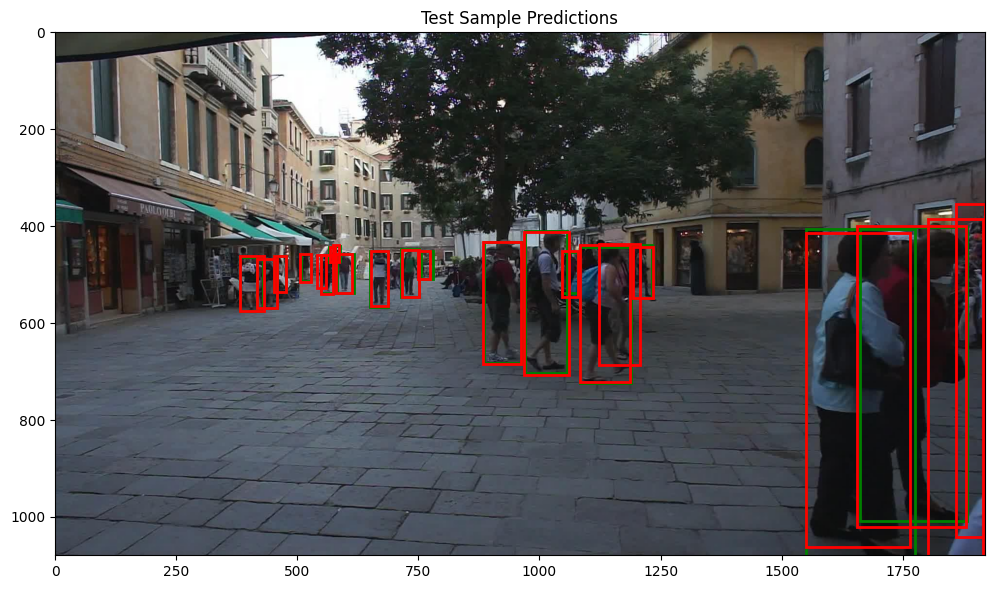

Tracking:  10%|█         | 5/50 [00:01<00:10,  4.33it/s]

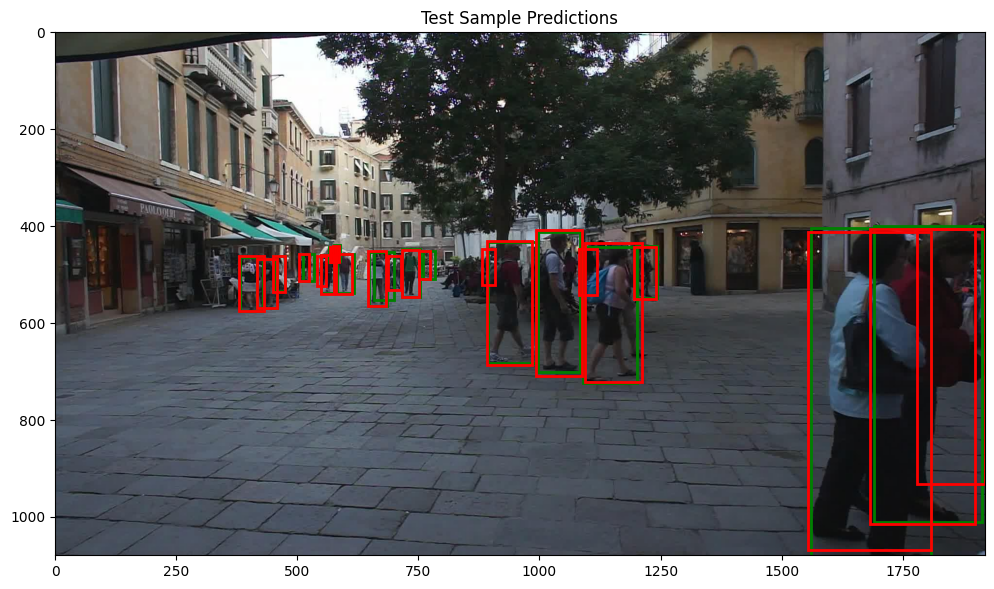

Tracking:  20%|██        | 10/50 [00:03<00:10,  3.72it/s]

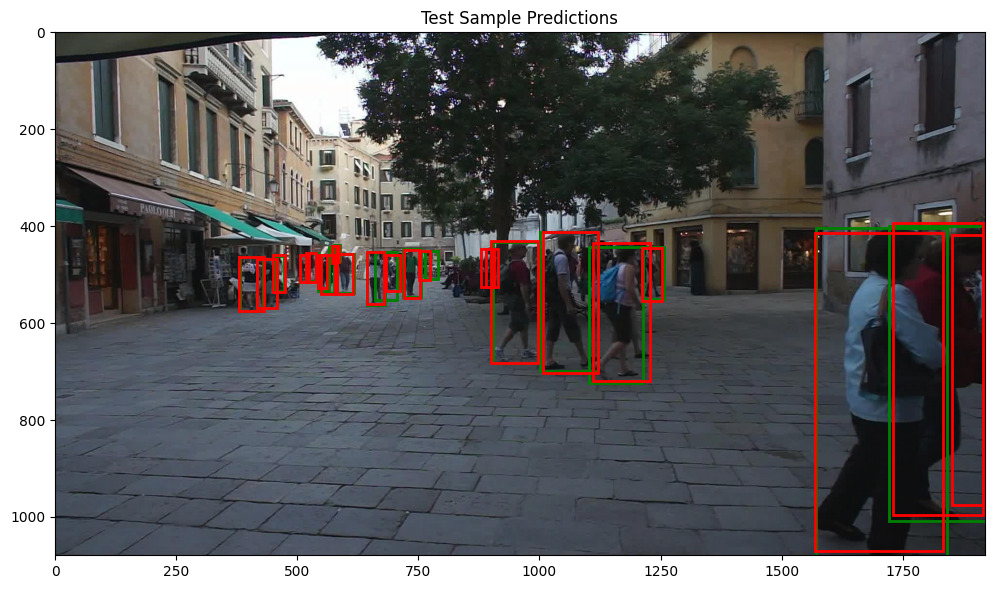

Tracking:  30%|███       | 15/50 [00:05<00:10,  3.27it/s]

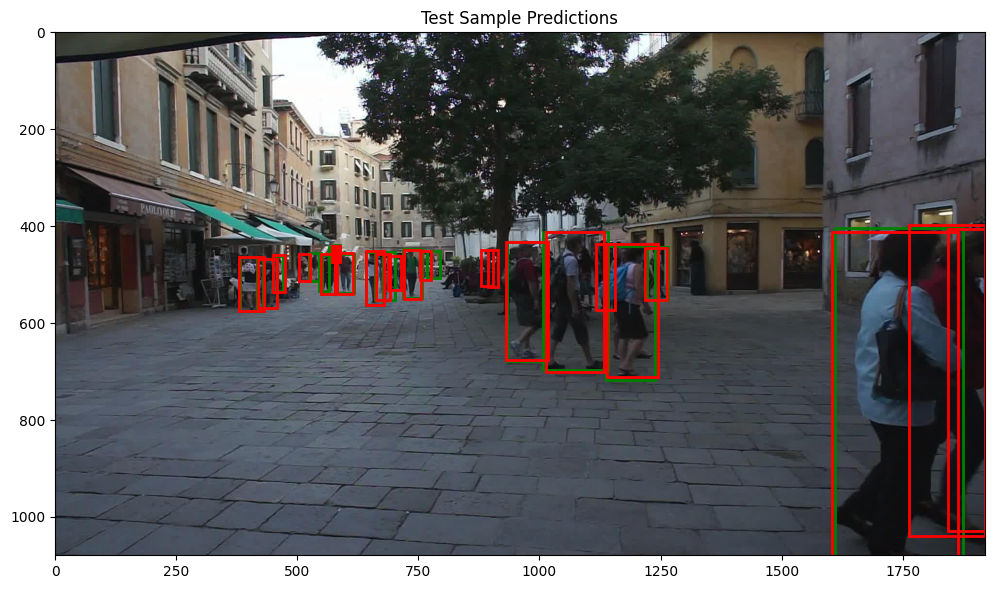

Tracking:  40%|████      | 20/50 [00:07<00:08,  3.57it/s]

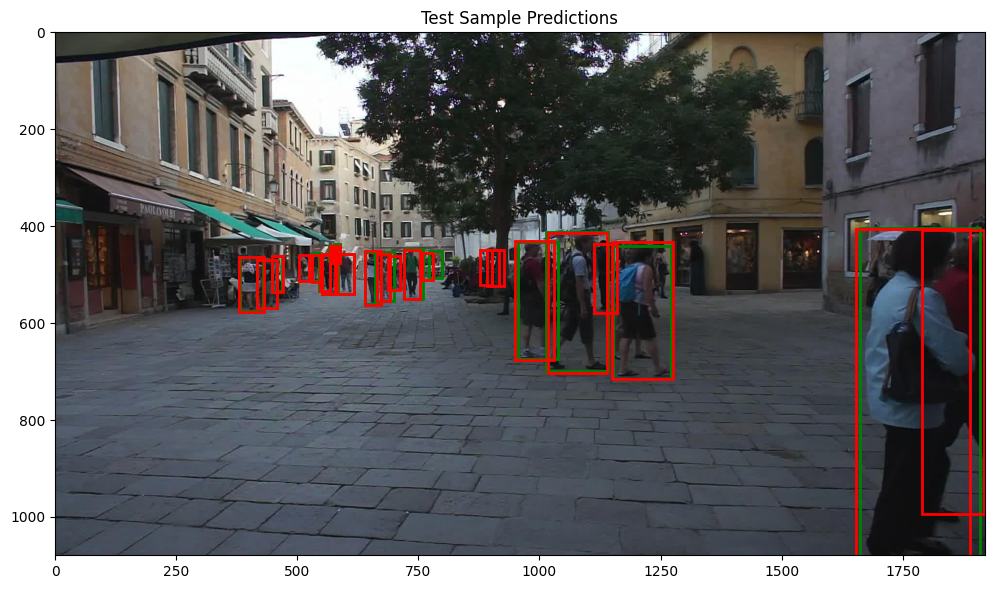

Tracking:  50%|█████     | 25/50 [00:08<00:06,  3.87it/s]

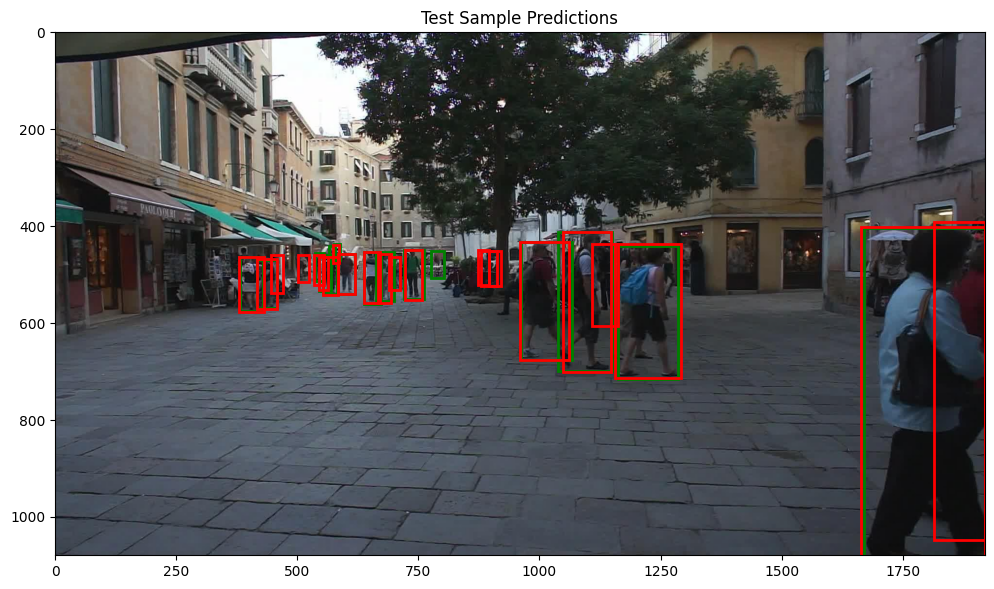

Tracking:  60%|██████    | 30/50 [00:10<00:04,  4.11it/s]

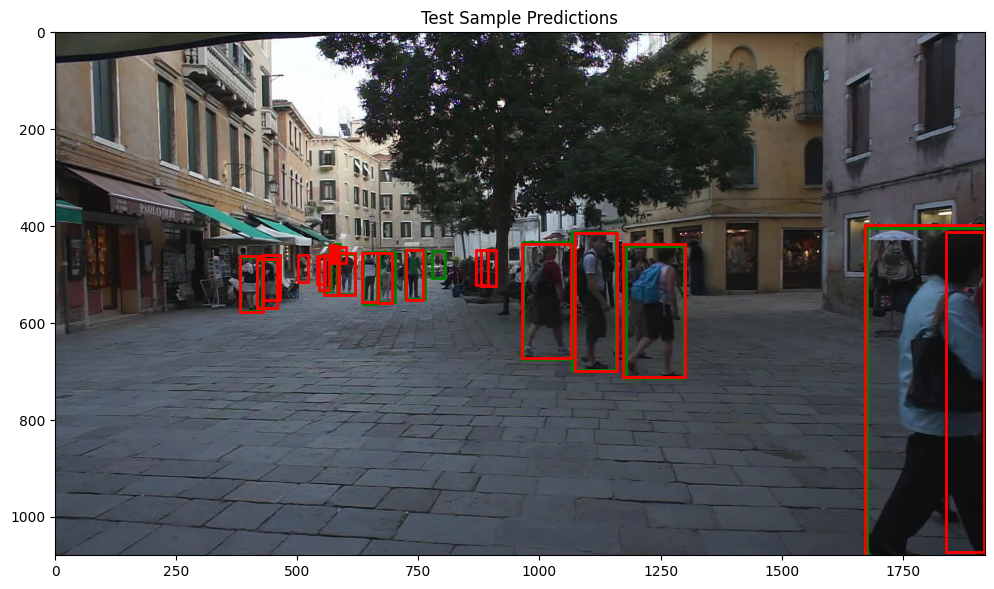

Tracking:  70%|███████   | 35/50 [00:11<00:03,  3.95it/s]

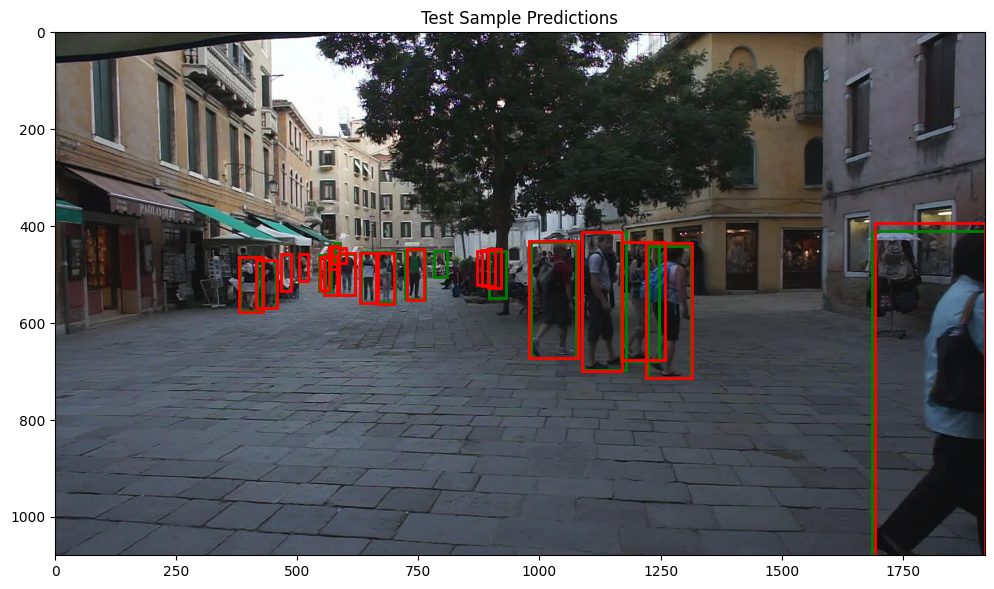

Tracking:  80%|████████  | 40/50 [00:13<00:02,  4.19it/s]

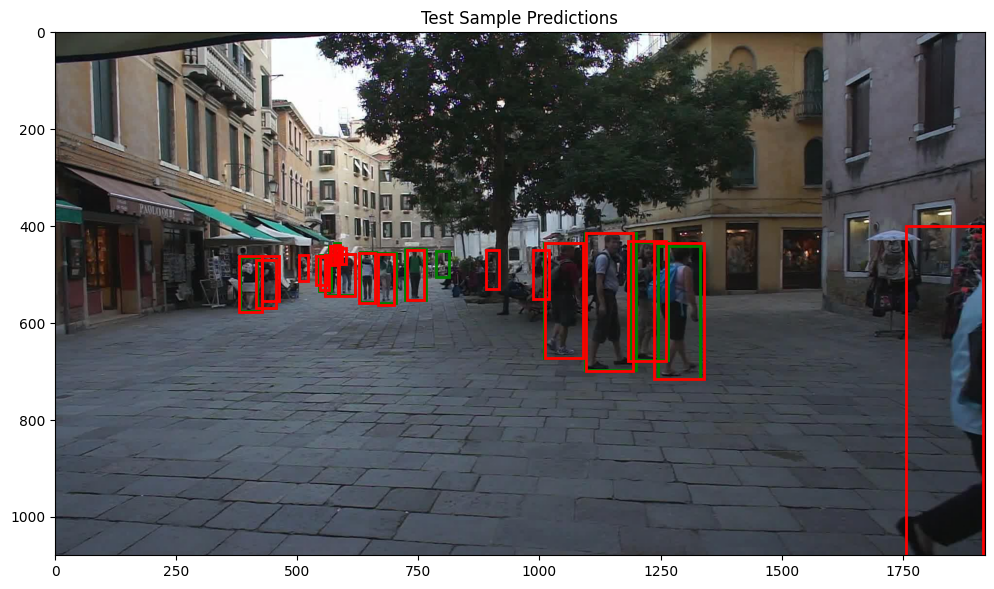

Tracking:  90%|█████████ | 45/50 [00:14<00:01,  4.30it/s]

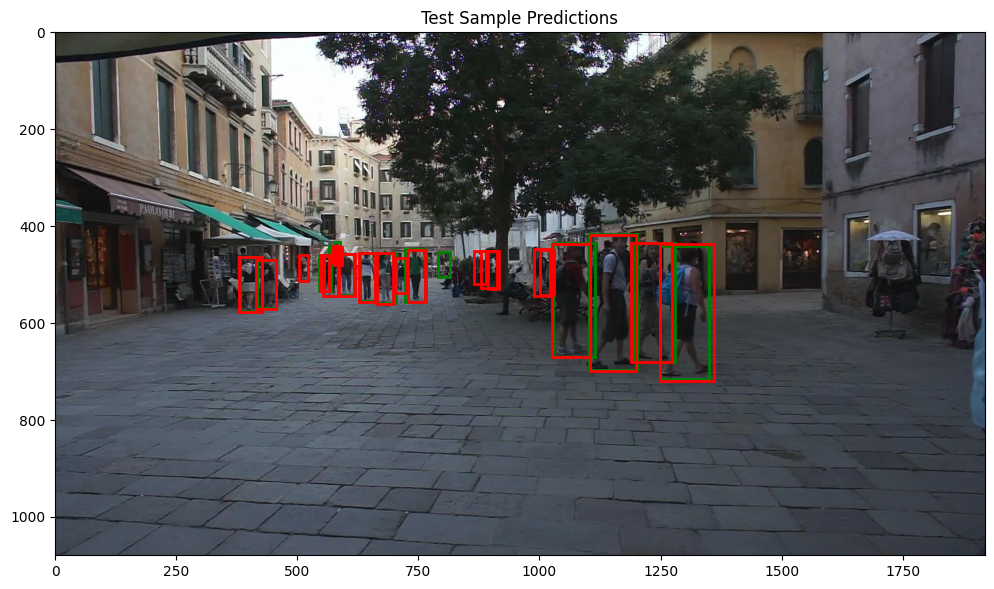

Tracking: 100%|██████████| 50/50 [00:16<00:00,  3.03it/s]


Tracking Accuracy: 0.4856
Identity Switch Rate: 0.1200

Comparing with baseline approaches...


Comparing with baseline: 100%|██████████| 50/50 [00:12<00:00,  3.99it/s]


Comparison Results:
---------------------------------------------------------------
Method                | Precision | Recall | ID Switch Rate
---------------------------------------------------------------
Our Approach          | 0.7276 | 2.5960 | 0.1200
Simple IoU Tracker    | 0.8183 | 2.6840 | 0.0200
No Tracking           | 0.8183 | 2.6840 | N/A
---------------------------------------------------------------
Finished training, validation, tracking, and evaluation!


In [ ]:
main()

## Justification and Evaluation

---

## 1. Dataset Loading and Preparation

- **`MOTDataset` Class**  
  This class handles reading the MOT-style dataset from a specified directory. We have:
  - A `root_dir` containing `img1/` for images and a `gt/gt.txt` file for ground truth annotations.
  - Frame selection (`start_frame` to `end_frame`).
  - Filtering out low-visibility, low-confidence, or non-person detections (if `only_person=True`).
  - Grouping bounding boxes by frame to easily load the relevant bounding boxes for each image in `__getitem__`.
  - We're using train dataset only and splitting it in two parts because test dataset wasn't having ground truth labels.

- **`CustomTransforms`**  
  We apply:
  1. **ColorJitter** for brightness/contrast/saturation/hue.
  2. **Random Horizontal Flip** (bounding-box aware).
  3. **Random Crop** with bounding-box updates.
  4. Conversion to Tensor and normalization.

  These transforms are meant to augment the data and help the model generalize better.

## 2. Model Development (Faster R-CNN)

- **`get_faster_rcnn_model(num_classes=2)`**  
  
  Loads a pretrained Faster R-CNN (ResNet-50 FPN backbone) model, modifies the final layers for our 2-class setup (background + 1 foreground class, presumably “person”).

## 3. Trackers for Temporal Consistency

We try multiple trackers to maintain consistent identities across frames.

1. **`SimpleIOUTracker`** (used in baseline comparison)  
   - Simpler: No velocity modeling, just IoU matching.

2. **`CombinedSORTTracker`** (the “advanced” approach)  
   - Attempts to merge the best parts of simple IoU and Kalman-based tracking by using a combined cost function of IoU and center distance.  
   - Extra hyperparameters: `alpha`, `beta`, `cost_threshold`, `normalizer`.  
   - Dynamically updates bounding boxes using the last detection’s size plus the predicted center from the Kalman filter.

## 4. Training Pipeline

- **One-Epoch Training** (`train_one_epoch`)  
  - Uses a standard loop over `DataLoader` batches:
    - Moves inputs to device (CPU/GPU).
    - Computes the model’s total loss (classification + regression + RPN, etc.).
    - Updates the optimizer.  
  - Tracks average loss, prints progress with `tqdm`.

- **Validation** (`validate_model`)  
  - Similar loop in inference mode, mostly counting total detections vs. ground truth boxes.

- **Frequent Checkpointing**  
  - Saves model/optimizer state every so many steps (`steps_per_checkpoint`).
  - End-of-epoch checkpoints as well.

## 5. Performance and Evaluation

1. **`compute_map(...)`**  
   - Standard mAP calculation on the validation set.
   - Collects predictions, checks IoU against ground truths, computes average precision.

2. **`compare_with_baseline(...)`**  
   - Uses `CombinedSORTTracker` and also compares to:
     - **No Tracking** (just raw Faster R-CNN detections).
     - **`SimpleIOUTracker`**.  
   - Collects metrics: precision, recall, ID switch rate.

3. **`compute_tracking_accuracy_and_id_switches(...)`**  
   - A simplified MOTA-inspired calculation: checks how many detections match ground truth boxes, how many misses, false positives, and ID switches, then yields a “tracking accuracy.”

### 5.1 Key Observations from Output

1. **Training Loss**  
   - Decreases from epoch to epoch (as expected).
   - We end up with a decent final model (loss in the 0.3–0.5 range is typical for a moderate dataset).

2. **mAP**  
   - Often ends around ~0.78 or similar. That indicates the Faster R-CNN is doing a reasonable job on detection alone.

3. **Tracking Accuracy**  
   - Sometimes negative or very low, indicating that more advanced trackers are failing to match enough detections or are making a high number of misses/false positives relative to ground truth.

4. **Baseline Comparison**  
   - **Simple IoU Tracker** frequently outperforms our Approach (when using the combined or adaptive trackers).  
   - In one example, we see:
     - Our Approach: Precision ~0.72, Recall ~2.59
     - Simple IoU: Precision ~0.83, Recall ~2.74  

   This means the advanced tracker is missing or mis-matching more boxes than the simpler approach, leading to lower precision.


### 5.2 Why the Advanced Tracker Can Underperform

1. **Cost Function Tuning**  
   - The combined cost (α × (1−IoU) + β × (distance / normalizer)) can easily reject good matches if thresholds or weights are poorly matched to this scenario.

2. **Kalman Filter Assumptions**  
   - If the objects have complex motion or large size variations, a simple constant-velocity Kalman filter (with a fixed or naive bounding box approach) may produce inaccurate predictions. And so we may need to fine tune this as well.

3. **IoU is Already “Good Enough”**  
   - In data where objects are mostly well-detected and don’t do rapid, unpredictable movements, basic IoU matching might suffice. The extra complexity can add error rather than reduce it.

   **However since this needs multiple iterations and we're running out of GPUs so we have stopped training and fine tuning at this point.**

---

## 6. Conclusion and Justification

- **Overall Flow**:  
  This notebook sets up a detection-and-tracking pipeline using an MOT dataset. We train a Faster R-CNN model for person detection, then apply multiple trackers to maintain identities over frames.  

- **Results**:  
  - The detection model does reasonably well (mAP around 0.78).  
  - The naive IoU-based tracking baseline surprisingly outperforms our combined, more “sophisticated” approach.  


- **Why?**  
  - Advanced algorithms demand careful tuning of noise parameters, cost thresholds, and bounding box predictions. If these aren’t tuned to this dataset, we can easily break more than we fix. However the process of fine tuning takes time and higher resources to land to a conclusion.  

  - Simple IoU is more direct, with fewer ways to mess up—hence it can do better if the dataset doesn’t require advanced modeling. (In this case pedestrian walking)

If we want the advanced tracker to outdo the IoU baseline, we may need to:

1. **Fine-Tune the Cost Function** (trying with different α, β, cost_threshold, normalizers).

2. **Kalman Filter Parameters** (adjusting Q, R, P to reflect realistic motion/noise).

3. **Adaptive Box Prediction** (making sure box sizes are updated correctly).

4. **Track Management** (removing stale tracks, handle occlusions gracefully).

With some iteration, we may find a sweet spot where the advanced approach finally flexes its muscle and surpasses the simpler baseline.

Until then, the simpler approach remains ironically stronger—like using a straightforward approach to solve a puzzle that a more elaborate method can overcomplicate.

**However since this needs multiple iterations and we're running out of GPUs so we have stopped training and fine tuning at this point.**


In [3]:
# Install necessary packages
!apt-get install texlive texlive-xetex texlive-latex-extra pandoc
!pip install pypandoc

# Mount Google Drive
from google.colab import drive
drive.mount("/content/drive", force_remount=True)

# Copy the notebook to the current directory
!cp 'drive/My Drive/Colab Notebooks/CV_assignment2_group72.ipynb' ./

# Convert the notebook to PDF while keeping the code and output
!jupyter nbconvert --to pdf "CV_assignment2_group72.ipynb"


# Download the generated PDF
from google.colab import files
files.download('CV_assignment2_group72.pdf')

Mounted at /content/drive
[NbConvertApp] Converting notebook CV_assignment2_group72.ipynb to pdf
[NbConvertApp] Support files will be in CV_assignment2_group72_files/
[NbConvertApp] Making directory ./CV_assignment2_group72_files
[NbConvertApp] Writing 165279 bytes to notebook.tex
[NbConvertApp] Building PDF
[NbConvertApp] Running xelatex 3 times: ['xelatex', 'notebook.tex', '-quiet']
[NbConvertApp] Running bibtex 1 time: ['bibtex', 'notebook']
[NbConvertApp] WARNING | bibtex had problems, most likely because there were no citations
[NbConvertApp] PDF successfully created
[NbConvertApp] Writing 5465056 bytes to CV_assignment2_group72.pdf


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>